# DEPLOYEZ UN MODELE DANS LE CLOUD: Test Local

### Contexte
Vous êtes Data Scientist dans une très jeune start-up de l'AgriTech, nommée  "Fruits!", qui cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.

Votre start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

Pour la start-up, cette application permettrait de sensibiliser le grand public à la biodiversité des fruits et de mettre en place une première version du moteur de classification des images de fruits.

De plus, le développement de l’application mobile permettra de construire une première version de l'architecture Big Data nécessaire.

### Mission

Vous êtes donc chargé de vous approprier les travaux réalisés par l’alternant et de compléter la chaîne de traitement.

Il n’est pas nécessaire d’entraîner un modèle pour le moment.

L’important est de mettre en place les premières briques de traitement qui serviront lorsqu’il faudra passer à l’échelle en termes de volume de données !

### Contraintes

Lors de son brief initial, Paul vous a averti des points suivants :

- Vous devrez tenir compte dans vos développements du fait que le volume de données va augmenter très rapidement après la livraison de ce projet. Vous continuerez donc à développer des scripts en Pyspark et à utiliser le cloud AWS pour profiter d’une architecture Big Data (EMR, S3, IAM). Si vous préférez, vous pourrez transférer les traitements dans un environnement Databricks.

- Vous devez faire une démonstration de la mise en place d’une instance EMR opérationnelle, ainsi qu’ expliquer pas à pas le script PySpark, que vous aurez complété :
  - d’un traitement de diffusion des poids du modèle Tensorflow sur les clusters (broadcast des “weights” du modèle) qui avait été oublié par l’alternant. Vous pourrez vous appuyer sur l’article “Distributed model inference using TensorFlow Keras” disponible dans les ressources
  - d’une étape de réduction de dimension de type PCA en PySpark

- Vous respecterez les contraintes du RGPD : dans notre contexte, vous veillerez à paramétrer votre installation afin d’utiliser des serveurs situés sur le territoire européen

- Votre retour critique de cette solution sera également précieuse, avant de décider de la généraliser

- La mise en œuvre d’une architecture Big Data de type EMR engendrera des coûts. Vous veillerez donc à ne maintenir l’instance EMR opérationnelle que pour les tests et les démos.

# DEPLOIEMENT DU SYSTEME EN LOCAL

# 1. Installation des packages et import des librairies

## 1.1. Installation des packages

In [1]:
pip install Pandas pillow tensorflow pyspark pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=80dff49160406f73b8410c82e36e6b39a761bdf80f7aa1a973e55056e71dac89
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


## 1.2. Import des librairies

In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split, udf
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import PCA

# 2. Définition des PATH pour le chargement des images et l'enregistrement des résultats

**Dans cette version en local, seul un échantillon de 300 images sera traité. Les images à charger sont stockés dans le dossier TestLocal et le résultat de leur traitement sera enregistré dans le dossier "Results".**

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
base_path = '/content/drive/MyDrive/Formation_DataScientist/Projet_8/TestLocal'

In [5]:
PATH_Result = os.path.join(base_path, 'Results')

print('PATH_Result: ', PATH_Result)

PATH_Result:  /content/drive/MyDrive/Formation_DataScientist/Projet_8/TestLocal/Results


# 3. Création de la SparkSession

L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé SparkSession. Une instance de SparkSession est la façon dont Spark exécute les fonctions définies par l’utilisateur dans l’ensemble du cluster. Une SparkSession correspond toujours à une application Spark.

**Une session spark sera créée en spécifiant dans l'ordre**:

1.   Nom pour l'application affichée dans l'interface utilisateur: Web Spark "P8"
2.   Exécution de l'application en local
3.   Option de configuration supplémentaire permettant d'utiliser le format "parquet"
4.   Création d'une session spark

In [6]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

<u>Création de la variable "**sc**" (**SparkContext**) issue de la variable **spark**</u>

In [7]:
sc = spark.sparkContext

<u>Affichage des informations de Spark en cours d'execution</u>

In [8]:
spark

# 4. Préparation des données

## 4.1. Chargement des données

In [9]:
# Chargement des images avec l'extension .jpg sous format binaire présentes dans les répertoires et sous-répertoires
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(base_path)

<u>Affichage des 5 premières images contenant</u>:
- Le path de l'image
- La date et l'heure de sa dernière modification
- Sa longueur
- Son contenu encodé en valeur hexadécimal

<u>Conservation unique du **path** et ajout d'une colonne contenant les **labels** de chaque image.<u>

In [10]:
# Ajout d'une nouvelle colonne 'label' au dataframe images
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))

# Impression des résultats
images.select('path','label').show(5,False)

# Impression du schéma du dataframe
print(images.printSchema())

+-------------------------------------------------------------------------------------------------+--------------+
|path                                                                                             |label         |
+-------------------------------------------------------------------------------------------------+--------------+
|file:/content/drive/MyDrive/Formation_DataScientist/Projet_8/TestLocal/Apple Golden 1/114_100.jpg|Apple Golden 1|
|file:/content/drive/MyDrive/Formation_DataScientist/Projet_8/TestLocal/Apple Golden 1/103_100.jpg|Apple Golden 1|
|file:/content/drive/MyDrive/Formation_DataScientist/Projet_8/TestLocal/Apple Golden 1/101_100.jpg|Apple Golden 1|
|file:/content/drive/MyDrive/Formation_DataScientist/Projet_8/TestLocal/Apple Golden 1/96_100.jpg |Apple Golden 1|
|file:/content/drive/MyDrive/Formation_DataScientist/Projet_8/TestLocal/Apple Golden 1/100_100.jpg|Apple Golden 1|
+-------------------------------------------------------------------------------

## 4.2. Préparation du modèle

Afin d'extraire les images, le **transfert learning** sera utilisé. Le choix s'est porté sur le modèle **MobileNetV2** pour sa rapidité d'exécution comparativement à d'autres modèles tel que le *VGG16*.

La dernière couche de ce modèle servant à classer les images selon 1000 catégories ne sera pas utilisée. L'idée de ce projet est de récupérer le vecteur de caractéristiques de dimensions (1,1,1280) qui servira, plus tard, au travers d'un moteur de classification à reconnaitre les différents fruits et légumes du jeu de données.

Comme d'autres modèles similaires, **MobileNetV2** nécessite des images de dimension (224,224,3). Les images de notre jeu de données étant de dimension (100,100,3), ces dernières devront donc être redimensionnées avant de les confier au modèle.

**Etapes à suivre dans l'ordre**:
1. Chargement du modèle **MobileNetV2** avec les poids précalculés issus d'imagenet en spécifiant le format de nos images en entrée.
2. Création d'un modèle avec:
  - En entrée: l'entrée du modèle MobileNetV2
  - En sortie:  l'avant-dernière couche du modèle MobileNetV2

In [11]:
model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

14536120/14536120 [==============================] - 0s 0us/step


In [12]:
new_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [13]:
# Résumé du modèle
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids.
Une bonne pratique consiste donc à charger le modèle sur le driver puis à diffuser ensuite les poids aux différents workeurs.

In [14]:
brodcast_weights = sc.broadcast(new_model.get_weights())

**Fonction pour le modèle**

In [15]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

## 4.3. Définition du processus de chargement des images et application de leur featurisation à travers l'utilisation de pandas UDF

L'empilement des appels est la suivante :
- Pandas UDF
  - Featuriser une série d'images pd.Series
    - Prétraitement d'une image

In [16]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


## 4.4. Exécution des actions d'extraction de features

### 4.4.1. Extraction des features de 300 images issues du jeu de données test

<u>Afin d'avoir 300 images avec 2 fruits différents, j'ai sélectionné les dossiers de 2 fruits: (i) le dossier Pommes Golden 1 contenant chacun 160 et (ii) le dossier Apricot contenant 164 images.<u>

Ainsi, le code ci-dessous conduira à la récupération des 160 images de pommes et de 140 images d'abricots.

In [17]:
# Tri du DataFrame par le chemin des images
sorted_images = images.orderBy("path")

# Limititation aux 300 premières images après le tri
limited_images = sorted_images.limit(300)

# Extraction des features en utilisant 20 exécuteurs
features_df = limited_images.repartition(20).select(
    col("path"),
    col("label"),
    featurize_udf("content").alias("features")
)

# Visualisation de 5 lignes au hasard du DataFrame obtenu
features_df.show(5, truncate=True)

+--------------------+--------------+--------------------+
|                path|         label|            features|
+--------------------+--------------+--------------------+
|file:/content/dri...|Apple Golden 1|[0.0, 0.028245566...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.19217406,...|
|file:/content/dri...|       Apricot|[0.4983322, 0.302...|
|file:/content/dri...|       Apricot|[0.7736844, 0.042...|
|file:/content/dri...|       Apricot|[0.84631646, 0.27...|
+--------------------+--------------+--------------------+
only showing top 5 rows



### 4.2.2. Réalisation d'une PCA

En général, lors d'une PCA, nous cherchons à atteindre 99% voire 95% de la variance expliquée. Pour la réalisation de cette dernière, il est nécessaire que la colonne soit de type vecteur.

<u>Détermination du nombre de composantes nécessaires pour atteindre 99% de la variance expliquée<u>

In [18]:
# Affichage du schéma du DataFrame pour identifier le type de la colonne features
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



Cette dernière étant de type array, une conversion en vecteur est donc nécessaire.

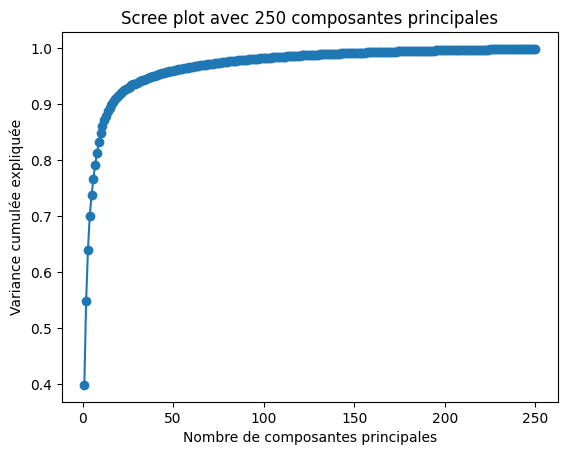

Nombre de composantes pour atteindre 99.0% de la variance expliquée : 137


In [19]:
# Définition d'une fonction UDF pour convertir la colonne "features" en vecteur
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Application de la fonction UDF pour la création d'une nouvelle colonne "features_vector"
features_df = features_df.withColumn("features_vector", array_to_vector_udf(features_df["features"]))

# Création d'un objet PCA avec un grand nombre de composantes principales
pca_high_dimensions = PCA(k=250, inputCol="features_vector", outputCol="pca_features_high_dimensions")

# Application de la PCA sur le DataFrame
model_high_dimensions = pca_high_dimensions.fit(features_df)

# Obtention de la variance expliquée par chaque composante principale
explained_variance_high_dimensions = model_high_dimensions.explainedVariance

# Calcul de la variance cumulée
cumulative_variance_high_dimensions = [sum(explained_variance_high_dimensions[:i+1]) for i in range(len(explained_variance_high_dimensions))]

# Traçage du Scree plot
plt.plot(range(1, len(explained_variance_high_dimensions) + 1), cumulative_variance_high_dimensions, marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance cumulée expliquée")
plt.title("Scree plot avec 250 composantes principales")
plt.show()

# Recherche du nombre de composantes nécessaires pour atteindre 99% de la variance expliquée
cumulative_variance_threshold = 0.99
num_components_threshold = next(i for i, var in enumerate(cumulative_variance_high_dimensions) if var >= cumulative_variance_threshold)

# Affichage du nombre de composantes nécessaires
print(f"Nombre de composantes pour atteindre {cumulative_variance_threshold * 100}% de la variance expliquée : {num_components_threshold}")

La PCA sera donc réalisée sur 137 composantes.

<u>Réalisation de la PCA avec 137 composantes<u>

In [20]:
# Création d'un objet PCA avec les 137 composantes principales pour atteindre 99% de la variance
pca = PCA(k=137, inputCol="features_vector", outputCol="vectorized_pca_features")

# Application de la PCA sur le DataFrame
model = pca.fit(features_df)
pca_features_df = model.transform(features_df)

# Sélection des colonnes pertinentes et affichage de 5 lignes au hasard
features_df_pca = pca_features_df.select("path", "label", "vectorized_pca_features")
features_df_pca.show(5, truncate=True)

+--------------------+--------------+-----------------------+
|                path|         label|vectorized_pca_features|
+--------------------+--------------+-----------------------+
|file:/content/dri...|Apple Golden 1|   [5.99172577288671...|
|file:/content/dri...|Apple Golden 1|   [4.32117924289719...|
|file:/content/dri...|       Apricot|   [-12.901975655860...|
|file:/content/dri...|       Apricot|   [-9.9304830996275...|
|file:/content/dri...|       Apricot|   [-14.146317783787...|
+--------------------+--------------+-----------------------+
only showing top 5 rows



<u>Afin de réaliser la PCA, nous avions vectoriser les features. Il serait donc intéressant de les restructurer.<u>

In [21]:
from pyspark.sql.types import ArrayType, FloatType

# Définition explicite de la fonction UDF
def vector_to_array(vec):
    return vec.toArray().tolist()

# Conversion de la fonction Python en UDF
vector_to_array_udf = udf(vector_to_array, ArrayType(FloatType()))

# Application de la fonction UDF pour la création d'une nouvelle colonne "pca_features"
final_df = features_df_pca.withColumn("pca_features", vector_to_array_udf("vectorized_pca_features"))

# Sélectionner les colonnes pertinentes et afficher les 5 premières lignes
final_df = final_df.select("path", "label", "pca_features")
final_df.show(5, truncate=True)

+--------------------+--------------+--------------------+
|                path|         label|        pca_features|
+--------------------+--------------+--------------------+
|file:/content/dri...|Apple Golden 1|[5.991726, -2.285...|
|file:/content/dri...|Apple Golden 1|[4.3211794, 3.384...|
|file:/content/dri...|       Apricot|[-12.901976, -4.9...|
|file:/content/dri...|       Apricot|[-9.930483, 10.97...|
|file:/content/dri...|       Apricot|[-14.1463175, -5....|
+--------------------+--------------+--------------------+
only showing top 5 rows



In [22]:
# Affichage du schéma du DataFrame pour identifier le type de la colonne pca_features
final_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- pca_features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [23]:
# Localisation des résultats
print(PATH_Result)

/content/drive/MyDrive/Formation_DataScientist/Projet_8/TestLocal/Results


<u>Enregistrement des données traitées au format "**parquet**"</u> :

In [24]:
# Enregistrement des données
final_df.write.mode("overwrite").parquet(PATH_Result)

## 4.3. Chargement des données enregistrées et validation du résultat

<u>Chargement des données fraichement enregistrées dans un **DataFrame Pandas**</u>

In [25]:
# Chargement des données depuis mon cloud :
df = pd.read_parquet(PATH_Result, engine='pyarrow')

<u>Affichage des 5 premières lignes du DataFrame</u>

In [26]:
df.head()

,path,label,pca_features
0,file:/content/drive/MyDrive/Formation_DataScie...,Apple Golden 1,"[5.991726, -2.285854, -2.1955826, 5.2626786, 1..."
1,file:/content/drive/MyDrive/Formation_DataScie...,Apple Golden 1,"[4.3211794, 3.3845124, 8.31036, 3.3782592, 0.5..."
2,file:/content/drive/MyDrive/Formation_DataScie...,Apricot,"[-12.901976, -4.9737554, 3.5158083, 6.0473294,..."
3,file:/content/drive/MyDrive/Formation_DataScie...,Apricot,"[-9.930483, 10.975159, -3.1531115, 4.096848, -..."
4,file:/content/drive/MyDrive/Formation_DataScie...,Apricot,"[-14.1463175, -5.645489, 2.3517957, 5.4195046,..."


<u>Validation de la dimension du vecteur de caractéristiques des images (attendu: 137)</u>

In [27]:
df.loc[0,'pca_features'].shape

(137,)

<u>Création d'une colonne pour chaque composante tout en conservant la colonne d'origine</u>

In [28]:
# Création d'une liste de colonnes à ajouter
new_columns = []

# Ajout des 137 composantes du vecteur en colonnes individuelles
num_components = 137

for i in range(num_components):
    new_columns.append(pd.Series(df['pca_features'].apply(lambda x: x[i] if isinstance(x, np.ndarray) and i < len(x) else np.nan), name=f'pca_feature_{i+1}'))

# Utilisation pd.concat pour ajouter toutes les colonnes à la fois
complete_df = pd.concat([df] + new_columns, axis=1)

<u>Dimension du dataframe</u>

In [29]:
complete_df.shape

(300, 140)

<u>Elimination de la colonne 'pca_features'<u>

In [30]:
uncomplete_df = complete_df.drop('pca_features', axis=1)

In [31]:
# Affichage des 5 premières lignes
uncomplete_df.head()

,path,label,pca_feature_1,pca_feature_2,pca_feature_3,pca_feature_4,pca_feature_5,pca_feature_6,pca_feature_7,pca_feature_8,...,pca_feature_128,pca_feature_129,pca_feature_130,pca_feature_131,pca_feature_132,pca_feature_133,pca_feature_134,pca_feature_135,pca_feature_136,pca_feature_137
0,file:/content/drive/MyDrive/Formation_DataScie...,Apple Golden 1,5.991726,-2.285854,-2.195583,5.262679,1.506263,1.260405,0.816207,0.596456,...,-0.126611,-0.233315,0.741901,-0.139557,-0.057772,1.528868,-0.544915,-0.046222,0.239621,0.410574
1,file:/content/drive/MyDrive/Formation_DataScie...,Apple Golden 1,4.321179,3.384512,8.310360,3.378259,0.587164,1.962405,1.886086,-5.246759,...,0.105110,-0.415781,0.816242,0.042734,-0.131155,1.558962,-0.384371,0.023106,0.260099,0.412606
2,file:/content/drive/MyDrive/Formation_DataScie...,Apricot,-12.901976,-4.973755,3.515808,6.047329,0.358323,0.514125,-2.303655,-2.260306,...,-0.075114,-0.429041,0.867979,-0.039895,-0.387553,1.431240,0.012174,-0.076005,0.354648,0.503433
3,file:/content/drive/MyDrive/Formation_DataScie...,Apricot,-9.930483,10.975159,-3.153111,4.096848,-3.026797,-3.449730,-0.052590,-2.360409,...,0.590321,-0.452360,0.555678,-0.506549,-0.325680,1.764636,-0.298572,-0.074754,0.621063,0.387928
4,file:/content/drive/MyDrive/Formation_DataScie...,Apricot,-14.146317,-5.645489,2.351796,5.419505,0.762879,1.260823,-4.391215,-2.205802,...,0.172936,-0.359682,0.745466,-0.236222,0.052808,1.490084,-0.263805,0.062318,0.341023,0.637828


<u>Comptage du nombre d'images de fruits/légumes par classe</u>

In [32]:
uncomplete_df['label'].value_counts()

Apple Golden 1    160
Apricot           140
Name: label, dtype: int64

Nous venons de valider le processus sur un jeu de données allégé en local
où nous avons simulé un cluster de machines en répartissant la charge de travail sur différents cœurs de processeur au sein d'une même machine.